In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
!pip install -q transformers datasets scikit-learn tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 9.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 40.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, b

In [4]:
# imports
import os
import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


2025-10-25 09:30:12.007633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761384612.207722      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761384612.262894      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda


In [5]:
# Model configuration
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS_INITIAL = 2    
TOTAL_EPOCHS = 5      
LR = 2e-5
OUTPUT_DIR = "/kaggle/working/sentiment140_bert"
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "checkpoint.pt")
os.makedirs(OUTPUT_DIR, exist_ok=True)

use_amp = torch.cuda.is_available()
print("AMP enabled:", use_amp)


AMP enabled: True


In [6]:
print("Loading dataset...")

# Load and preprocess data
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding='latin-1', 
                 header=None, 
                 names=['sentiment','id','date','query','user','text'])

df = df[['text', 'sentiment']].copy()
df['label'] = df['sentiment'].map({0: 0, 4: 1})
df = df[['text', 'label']]
df.head()



Loading dataset...


,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
# Tweet cleaning function
def clean_tweet(t):
    if not isinstance(t, str): 
        return ""
    t = re.sub(r"http\S+", " ", t)
    t = re.sub(r"@\S+", " ", t)
    t = re.sub(r"[^A-Za-z0-9\s']", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t.lower()

df['text'] = df['text'].map(clean_tweet)
df.head()


,text,label
0,awww that's a bummer you shoulda got david car...,0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it's not behaving at all i'm mad why am i h...,0


In [8]:
# Data split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

print("Train / Val / Test sizes:", len(train_df), len(val_df), len(test_df))


Train / Val / Test sizes: 1280000 160000 160000


In [9]:
# Tokenization
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def encode_texts(texts):
    return tokenizer(list(texts), padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")

train_enc = encode_texts(train_df["text"].tolist())
val_enc = encode_texts(val_df["text"].tolist())
test_enc = encode_texts(test_df["text"].tolist())

train_labels = torch.tensor(train_df["label"].values, dtype=torch.long)
val_labels = torch.tensor(val_df["label"].values, dtype=torch.long)
test_labels = torch.tensor(test_df["label"].values, dtype=torch.long)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
class TorchSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets and dataloaders
train_dataset = TorchSentimentDataset(train_enc, train_labels)
val_dataset = TorchSentimentDataset(val_enc, val_labels)
test_dataset = TorchSentimentDataset(test_enc, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)


In [12]:
# Initialize model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2,  hidden_dropout_prob=0.3,attention_probs_dropout_prob=0.3 ).to(device)
optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8)
total_steps = len(train_loader) * TOTAL_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def save_checkpoint(path, model, optimizer, scheduler, epoch):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, path)
    print(f"Checkpoint saved -> {path}")

def load_checkpoint(path, model, optimizer=None, scheduler=None, device=device):
    if not os.path.isfile(path):
        raise FileNotFoundError(path)
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    if optimizer and 'optimizer_state_dict' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler and 'scheduler_state_dict' in ckpt:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_epoch = ckpt.get('epoch', 0)
    print(f"Loaded checkpoint from {path}, resuming at epoch {start_epoch+1}")
    return start_epoch

# Load checkpoint if exists
LOAD_CKPT = True
if LOAD_CKPT and os.path.exists(CHECKPOINT_PATH):
    start_epoch = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler, device)
else:
    start_epoch = 0


In [14]:
def train_one_epoch(model, loader, optimizer, scheduler, scaler):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(loader, desc="Train", leave=False)
    
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Her batch'te loss ve accuracy göster
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        pbar.set_postfix(loss=loss.item(), acc=batch_acc)
    
    # Epoch genel metrikleri
    avg_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")
    
    return avg_loss, epoch_acc, epoch_f1


In [15]:
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, f1, all_preds, all_labels


In [16]:
epochs_to_run = TOTAL_EPOCHS - start_epoch
print(f"Starting training from epoch {start_epoch+1} to {TOTAL_EPOCHS}...")

best_val_loss = float('inf')  # 🔹 Başlangıçta en kötü loss
patience = 1                  # 🔹 Kaç epoch boyunca iyileşme olmazsa duracak
counter = 0                   # 🔹 Sabır sayacı

for ep in range(start_epoch, start_epoch + epochs_to_run):
    t0 = time.time()

    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, scaler)
    val_loss, val_acc, val_f1, val_preds, val_trues = evaluate(model, val_loader)

    t1 = time.time()
    
    print(f"Epoch {ep+1} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | train_f1={train_f1:.4f} "
          f"| val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f} | time={(t1-t0)/60:.2f} min")

    # ✅ Modeli her epoch sonunda kaydet (senin orijinal kodun)
    save_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler, ep+1)

    # ✅ Early Stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Model improved and saved as 'best_model.pt'.")

    else:
        counter += 1
        print(f"⚠️ No improvement detected.({counter}/{patience})")

        if counter >= patience:
            print("⏹️ Early stopping triggered. Training is stopping.")
            break


Starting training from epoch 1 to 5...


Train:   0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 1 | train_loss=0.4008 | train_acc=0.8143 | train_f1=0.8143 | val_loss=0.3574 | val_acc=0.8501 | val_f1=0.8498 | time=132.26 min
Checkpoint saved -> /kaggle/working/sentiment140_bert/checkpoint.pt
✅ Model improved and saved as 'best_model.pt'.


Train:   0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 2 | train_loss=0.3399 | train_acc=0.8517 | train_f1=0.8517 | val_loss=0.3389 | val_acc=0.8587 | val_f1=0.8587 | time=132.50 min
Checkpoint saved -> /kaggle/working/sentiment140_bert/checkpoint.pt
✅ Model improved and saved as 'best_model.pt'.


Train:   0%|          | 0/40000 [00:00<?, ?it/s]

Epoch 3 | train_loss=0.3164 | train_acc=0.8637 | train_f1=0.8637 | val_loss=0.3515 | val_acc=0.8586 | val_f1=0.8584 | time=132.58 min
Checkpoint saved -> /kaggle/working/sentiment140_bert/checkpoint.pt
⚠️ No improvement detected.(1/1)
⏹️ Early stopping triggered. Training is stopping.


In [17]:
# Save final model
final_model_dir = os.path.join(OUTPUT_DIR, "final_model")
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
print("Final model saved to:", final_model_dir)


Final model saved to: /kaggle/working/sentiment140_bert/final_model


In [18]:
import torch
import os

ckpt_path = "/kaggle/working/sentiment140_bert/checkpoint.pt"

# Checkpoint var mı kontrol
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    print("✅ Checkpoint yüklendi!")
    print("Epoch:", ckpt.get('epoch'))
    print("Model state dict keys:", list(ckpt['model_state_dict'].keys())[:10], "...")  # sadece ilk 10 key
    print("Optimizer state dict keys:", list(ckpt['optimizer_state_dict'].keys())[:10], "...")
    print("Scheduler state dict keys:", list(ckpt['scheduler_state_dict'].keys())[:10], "...")
else:
    print("❌ Checkpoint bulunamadı.")


✅ Checkpoint yüklendi!
Epoch: 3
Model state dict keys: ['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight'] ...
Optimizer state dict keys: ['state', 'param_groups'] ...
Scheduler state dict keys: ['base_lrs', 'last_epoch', 'verbose', '_step_count', '_get_lr_called_within_step', '_last_lr', 'lr_lambdas'] ...



=== Final Test Results ===
Test loss: 0.3509, Test acc: 0.8593, Test f1: 0.8591

Classification report (test):
               precision    recall  f1-score   support

           0     0.8362    0.8936    0.8639     80000
           1     0.8858    0.8249    0.8543     80000

    accuracy                         0.8593    160000
   macro avg     0.8610    0.8593    0.8591    160000
weighted avg     0.8610    0.8593    0.8591    160000



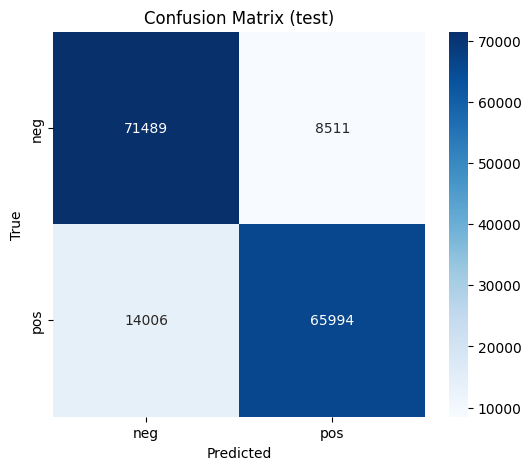

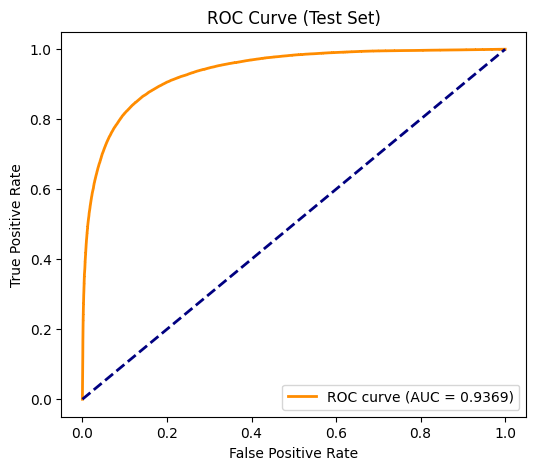

Final model saved to: /kaggle/working/sentiment140_bert/final_model


In [23]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Evaluation ===
test_loss, test_acc, test_f1, test_preds, test_trues = evaluate(model, test_loader)

print("\n=== Final Test Results ===")
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test f1: {test_f1:.4f}")
print("\nClassification report (test):\n", classification_report(test_trues, test_preds, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(test_trues, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["neg","pos"], yticklabels=["neg","pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (test)")
plt.show()

# === ROC Curve ===
# Modelin pozitif sınıfa ait olasılıklarını almak için evaluate fonksiyonunda logits döndürelim
# Eğer evaluate fonksiyonun logits döndürmüyorsa, küçük bir değişiklikle ekleyebilirsin.
# Aşağıdaki kodu ROC kısmında kullanmak için:
model.eval()
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # pozitif sınıf olasılığı
        all_probs.extend(probs.cpu().numpy())

# ROC eğrisi çizimi
fpr, tpr, thresholds = roc_curve(test_trues, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()

# === Save final model + tokenizer ===
final_model_dir = os.path.join(OUTPUT_DIR, "final_model")
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)
print("Final model saved to:", final_model_dir)
